# E2 

In this exercise, I will use two methods to show the optical flow. Both methods are gradient-based motion estimation.

In exercise1, I use my own funtion to get the motion vectors. But there is an important short in my results. The motion vectors include all pixels in the whole frame. I don't think this is correct. Because we know that only object move in the frames, not all pixels move. In this exercise, I will use **Shi_Tomasi** algorithm to get the corners. Because corner Detection is a method used in computer vision system to obtain image features and is widely used in motion Detection

# Method in demo

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import cv2
from scipy import signal

In [2]:
seq1 = {'I1': io.imread('data/image/seq1/frame1.png', as_grey=True),
        'I2': io.imread('data/image/seq1/frame3.png', as_grey=True),
        'U' : np.loadtxt('data/flow/seq1/flow3.u', dtype='double', delimiter=','),
        'V' : np.loadtxt('data/flow/seq1/flow3.v', dtype='double', delimiter=',')}
rubic = {'I1':io.imread('data/rubic/rubic.0.png', as_grey=True),
        'I2':io.imread('data/rubic/rubic.5.png', as_grey=True)}
sphere= {'I1': io.imread('data/sphere/sphere.1.png', as_grey=True),
        'I2': io.imread('data/sphere/sphere.3.png', as_grey=True)}
I = np.random.rand(128, 128)
synth = {'I1': I[0:100, 0:100], 
         'I2': I[2:102, 2:102]}

In [3]:
img_seq1 = cv2.imread('data/image/seq1/frame1.png') 
img_rubic = cv2.imread('data/rubic/rubic.0.png') 
img_sphere = cv2.imread('data/sphere/sphere.1.png') 

In [4]:
def quiver(I, X, Y, U, V, points):
    fig, ax = plt.subplots(figsize=(10, 10), dpi=80)
    ax.imshow(I, cmap='gray')
    u_mean = np.mean(U)
    v_mean = np.mean(V)
    for i in range (points):
        ax.quiver(X[i], Y[i], U[i]*10, V[i]*10, color='red', angles='xy',scale_units='xy', scale=1)      
    ax.set_aspect('equal')
    plt.show()

In [5]:
def derivative_components(I1, I2, x, y):
    h = I1.shape[0]
    w = I1.shape[1]
    x = int(x)
    y = int(y)
    if (x > 0) and (x < (w-1)) and (y >= 0) and y < h :
        Ix = (I1[y, x+1] - I1[y, x-1])/2
    else:
        Ix = 0
    if (x >= 0) and (x < w) and (y > 0) and (y < (h-1)):
        Iy = (I1[y+1, x] - I1[y-1, x])/2
    else:
        Iy = 0
    if (x >= 0) and (x < w) and (y >= 0) and (y < h):
        It=(I2[y, x] - I1[y, x])
    else:
        It = 0
    return (Ix, Iy, It)

In [6]:
def gradient (I1, I2, x, y, window):
    center = np.arange(0, window) - np.floor(window/2)
    dx, dy = np.meshgrid(center, center)
    dx = dx.reshape(window*window, 1)
    dy = dy.reshape(window*window, 1)
    A = np.zeros((window*window, 2))
    b = np.zeros(window*window)
    
    # get A and b
    for i in range(0, window*window):
        Ix, Iy, It = derivative_components(I1, I2, x+dx[i], y+dy[i])
        A[i, 0] = Ix 
        A[i, 1] = Iy
        b[i] = -It
    return (A, b)

In [7]:
def estimate_flow(I1,I2,x,y,window,points):
    size = x.shape 
    U = np.zeros((size))
    V = np.zeros((size))
    
    for i in range(points):
        A, b = gradient(I1, I2, x[i], y[i], window)
        flow = np.linalg.lstsq(np.matmul(A.T, A), np.matmul(A.T, b))
        v = flow[0]
        U[i] = v[0]
        V[i] = v[1]
    return (U, V) 

In [8]:
def Shi_Tomasi(img,points):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)  
    corners = cv2.goodFeaturesToTrack(gray,points,0.01,10)  
    x = np.zeros(corners.shape[0])
    y = np.zeros(corners.shape[0])
    for i in range (corners.shape[0]):
        x[i] = corners[i][0,0]
    for j in range (corners.shape[0]):
        y[j] = corners[j][0,1]
    return (x,y) 

In [9]:
def optical_flow(seq,img,points):
    x,y = Shi_Tomasi(img,points)
    window  =15 # size of window
    U, V = estimate_flow(seq["I1"], seq["I2"], x, y, window,points)
    quiver(seq["I1"], x, y, U, V, points)

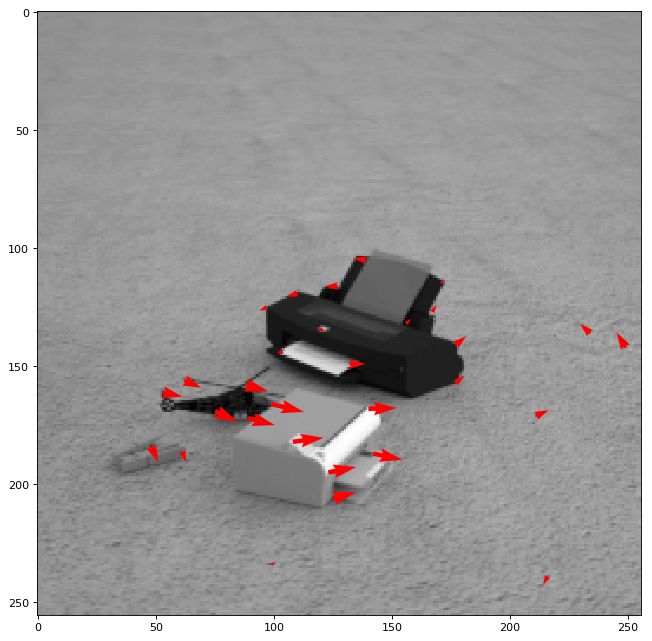

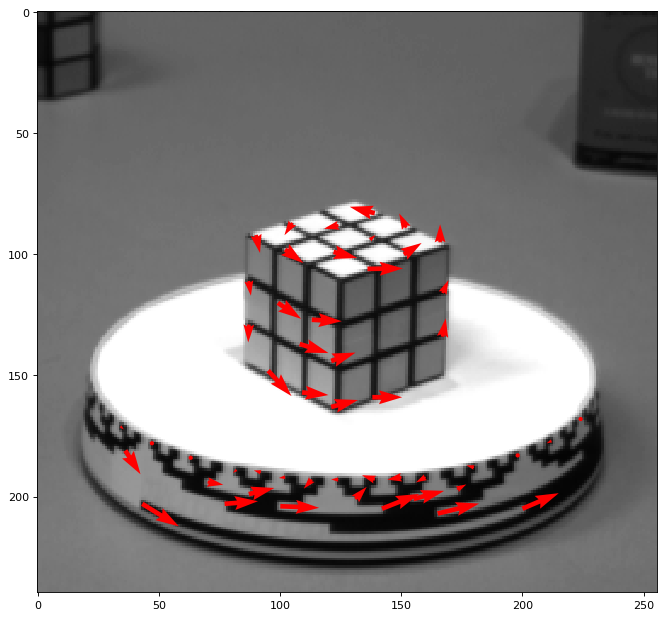

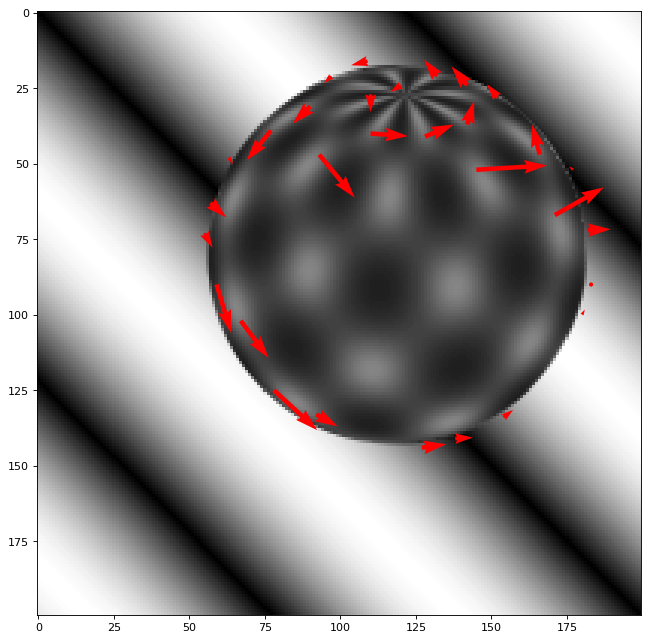

In [10]:
optical_flow(seq1,img_seq1,30)
optical_flow(rubic,img_rubic,50)
optical_flow(sphere,img_sphere,30)

## Lucas-Kanade method

Lucas-Kanade method is a famous gradient-based motion estimation.  
The Lucas–Kanade method assumes that the displacement of the image contents between two nearby instants (frames) is small and approximately constant within a neighborhood of the point p under consideration. Thus the optical flow equation can be assumed to hold for all pixels within a window centered at $p$
. Namely, the local image flow (velocity) vector $(V_{x},V_{y}) (V_{x},V_{y})$ must satisfy  
$I_x(q_1)V_x + I_y(q_1)V_y = - I_t(q_1) $  
$I_x(q_2)V_x + I_y(q_2)V_y = - I_t(q_2) $  
...  
$I_x(q_n)V_x + I_y(q_n)V_y = - I_t(q_n) $  

where $q_{1},q_{2},...q_{n}$ are the pixels inside the window, and $I_{x}(q_{i}),I_{y}(q_{i}),I_{t}(q_{i}) $are the partial derivatives of the image {\displaystyle I} I with respect to position x, y and time t, evaluated at the point $q_{i}$ and at the current time.

These equations can be written in matrix form $Av=b$, where  
$ A=\left[
\begin{aligned}
I_x(q_1) \quad &I_y(q_2) \\
I_x(q_2) \quad &I_y(q_2) \\
... \quad ...\\
I_x(q_n \quad &I_y(q_n) \\
\end{aligned}
\right]
$
$ v=\left[
\begin{aligned}
V_x\\
V_y\\
\end{aligned}
\right]
$
$ b=\left[
\begin{aligned}
-I_t(q_1)\\
-I_t(q_1)\\
...\\
-I_t(q_n)\\
\end{aligned}
\right]
$  

This system has more equations than unknowns and thus it is usually over-determined. The Lucas–Kanade method obtains a compromise solution by the least squares principle. Namely, it solves the 2×2 system  
$A^TA_v = A^Tb$ or $v = (A^TA)^{-1}A^Tb$  
where $A^{T}$ is the transpose of matrix $A$. That is, it computes  
$ \left[
\begin{aligned}
V_x\\
V_y\\
\end{aligned}
\right]
$
$=$
$ \left[
\begin{aligned}
\sum_iI_x(q_i)^2\quad \sum_iI_x(q_i)I_y(q_i)\\
\sum_iI_y(q_i)I_x(q_i)\quad \sum_iI_y(q_i)^2\\
\end{aligned}
\right]^{-1}
\left[
\begin{aligned}
-\sum_iI_x(q_i)I_t(q_i)\\
-\sum_iI_y(q_i)I_t(q_i)\\
\end{aligned}
\right]
$  
where the central matrix in the equation is an Inverse matrix. The sums are running from $i=1$ to n.
The matrix $A^{T}A$ is often called the structure tensor of the image at the point $p$.

In [11]:
Im1_seq1 = cv2.imread('data/image/seq1/frame1.png') 
Im2_seq1 = cv2.imread('data/image/seq1/frame3.png') 
Im1_rubic  = cv2.imread('data/rubic/rubic.0.png') 
Im2_rubic  = cv2.imread('data/rubic/rubic.5.png') 
Im1_sphere  = cv2.imread('data/sphere/sphere.1.png') 
Im2_sphere  = cv2.imread('data/sphere/sphere.3.png') 

In [12]:
def quiver_1(I, X, Y, U, V, points):
    fig, ax = plt.subplots(figsize=(10, 10), dpi=80)
    ax.imshow(I, cmap='gray')
    u_mean = np.mean(U)
    v_mean = np.mean(V)
    for i in range (points):
        ax.quiver(X[i], Y[i], -U[i]*10, -V[i]*10, color='red', angles='xy',scale_units='xy', scale=1)      
    ax.set_aspect('equal')
    plt.show()

def derivative_components_1(Im1, Im2):
    Kernel_x = np.array([[-0.5,0.5],
                          [-0.5,0.5]])
    Kernel_y = np.array([[-0.5,-0.5],
                          [0.5,0.5]])
    Kernel_t = np.array([[-0.5,-0.5],
                          [-0.5,-0.5]])
    Dx = cv2.filter2D(Im1, -1,Kernel_x) + cv2.filter2D(Im2,-1, Kernel_x)
    Dy = cv2.filter2D(Im1, -1,Kernel_y) + cv2.filter2D(Im2, -1,Kernel_y)
    Dt = cv2.filter2D(Im1, -1,Kernel_t) + cv2.filter2D(Im2, -1,-Kernel_t)
    return (Dx,Dy,Dt)

In [13]:
def Lucas_Kanade (Im1, Im2, ws,points):
    gray1 = cv2.cvtColor(Im1,cv2.COLOR_BGR2GRAY)  
    gray2 = cv2.cvtColor(Im2,cv2.COLOR_BGR2GRAY)
    gray1 = np.float32(gray1)
    gray2 = np.float32(gray2)
    corners = cv2.goodFeaturesToTrack(gray1,points,0.01,10) 
    x = np.zeros(corners.shape[0])
    y = np.zeros(corners.shape[0])
    for i in range (corners.shape[0]):
        x[i] = corners[i][0,0]
    for j in range (corners.shape[0]):
        y[j] = corners[j][0,1]
    
    m,n = gray1.shape
    w = ws//2
    U = np.zeros((x.shape))
    V = np.zeros((y.shape))
    Kernel_x = np.array([[-1,1],
                          [-1,1]])
    Kernel_y = np.array([[-1,-1],
                          [1,1]])
    Kernel_t = np.array([[-1,-1],
                          [-1,-1]])
    Dx = signal.convolve2d(gray1, Kernel_x, mode='same') + signal.convolve2d(gray2, Kernel_x, mode='same')
    Dy = signal.convolve2d(gray1, Kernel_y, mode='same') + signal.convolve2d(gray2, Kernel_y, mode='same')
    Dt = signal.convolve2d(gray1, Kernel_t, mode='same') + signal.convolve2d(gray2, -Kernel_t, mode='same')
    #Dx = cv2.filter2D(gray1, -1,Kernel_x) + cv2.filter2D(gray2,-1, Kernel_x)
    #Dy = cv2.filter2D(gray1, -1,Kernel_y) + cv2.filter2D(gray2, -1,Kernel_y)
    #Dt = cv2.filter2D(gray1, -1,Kernel_t) + cv2.filter2D(gray2, -1,-Kernel_t)
    A = np.zeros([(2*w)*(2*w),2])
    b = np.zeros([(2*w)*(2*w),1])
    for i in range(points):
        x1 = int(x[i])
        y1 = int(y[i])
        Ix = Dx[y1-w:y1+w, x1-w:x1+w].T
        Iy = Dy[y1-w:y1+w, x1-w:x1+w].T
        It = Dt[y1-w:y1+w, x1-w:x1+w].T

        Ix1 = Ix.reshape((Ix.shape[0]*Ix.shape[0]),order='F') 
        Iy1 = Iy.reshape((Iy.shape[0]*Iy.shape[0]),order='F') 
        It1 = It.reshape((It.shape[0]*It.shape[0]),order='F')        
        A[:,0] = Ix1
        A[:,1] = Iy1
        b = -It1
        Y = np.linalg.pinv(A)
        X = np.dot(Y,b)
        U[i] = X[0]
        V[i] = X[1]
    return(U,V,x,y,gray1)
    
    

In [14]:
def main(Im1,Im2,ws,points):
    (U,V,x,y,gray1) = Lucas_Kanade (Im1, Im2, ws,points)
    quiver_1(gray1, x, y, U, V, points)

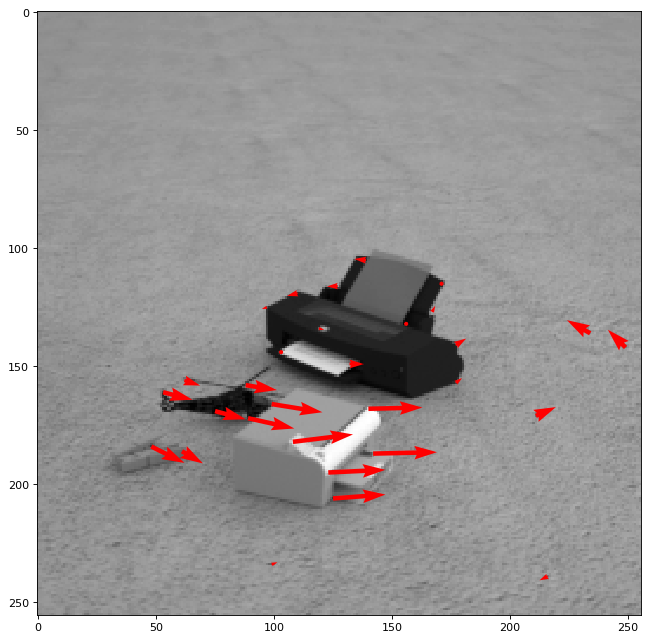

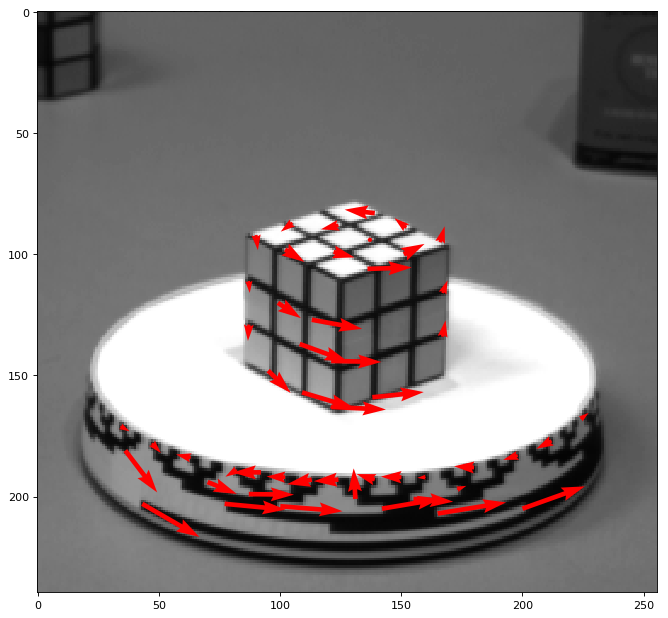

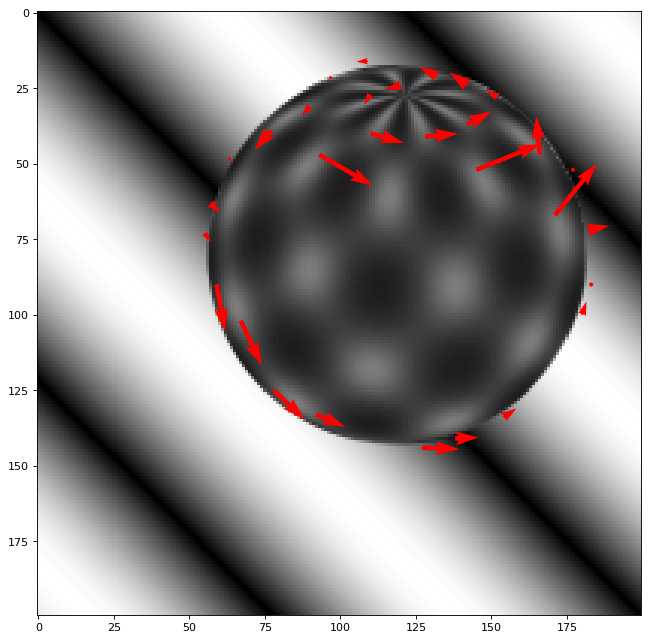

In [15]:
main(Im1_seq1,Im2_seq1,15,30)
main(Im1_rubic,Im2_rubic,15,50)
main(Im1_sphere,Im2_sphere,15,30)

## Conclusion: 
### (1)
Because I use the Shi_Tomasi algorithm to get the corners, so only corners have motion vectors. There is no motion vectors in background, only the moving object has the motion vectors.  For example, in rubic, motion vectors only show in the cube and dial. And in sphere, only the ball has motion vectors, that is what I want. But in seq1, the result is worse, there are still some motion vectors in background. All in all, these results are better than the results in exercise. The motion vectors are more accurate than exercise 1.  
### (2) 
The comparison between method in demo and LK, different pictures has different results. In seq1, LK has little less motion vectors in dackground. And I think the corners which has stronger movement, the motion vectors are more prominent. 